In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Standard scientific Python imports and Import  classifiers

In [ ]:
import numpy as np
from numpy import linalg
from numpy.linalg import norm
import random
import cv2
import os
from imutils import paths
#We import sklearn.
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from keras.regularizers import l2


# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt


Using TensorFlow backend.


# Loading training and testing data (MINST)

Training X matrix shape (60000, 28, 28, 1)
---------------------------------------- 
Testing X matrix shape (10000, 28, 28, 1)
---------------------------------------- 
y Train Shape is :  (60000, 10)
---------------------------------------- 
y Test Shape is :  (10000, 10)
---------------------------------------- 
All y is :  [0 1]


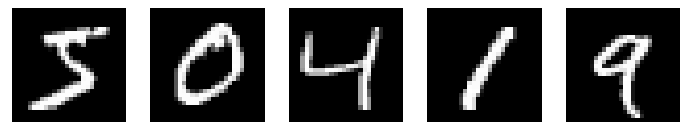

In [ ]:
# Load data.
(X_train , y_train),(X_test, y_test) = tf.keras.datasets.mnist.load_data()

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255 # Original data is uint8 (0-255). Scale it to range [0,1].
X_test  /= 255

#binarize the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

print("Training X matrix shape", X_train.shape)
print('---------------------------------------- ')
print("Testing X matrix shape", X_test.shape)
print('---------------------------------------- ')
print('y Train Shape is : ' , y_train.shape)
print('---------------------------------------- ')
print('y Test Shape is : ' , y_test.shape)
print('---------------------------------------- ')
print('All y is : ' , np.unique( y_train ))

plt.figure(figsize=(12,10))
plt.style.use('ggplot')
for i in  range(5)  :
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])


# Creating clients and batching training and testing data

In [ ]:
def create_clients(image_list, label_list, num_clients, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as
                data shards - tuple of images and label lists.
        args:
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1

    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

def batch_data(data_shard, batch_size):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(batch_size)


In [ ]:
#create clients
comms_round = 100
n_clients = 10
batch_size = 128
clients = create_clients(X_train, y_train, n_clients, initial='client')

#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data, batch_size)

#process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

# Creating a model with Keras

* INPUT: 28 × 28 × 1
* CONV5: 5 × 5 size, 32 filters, 1 stride
* ReLU: max(0,hθ(x))
* POOL: 2 × 2 size, 1 stride
* CONV5: 5 × 5 size, 64 filters, 1 stride
* ReLU: max(0,hθ(x))
* POOL: 2 × 2 size, 1 stride
* FC: 1024 Hidden Neurons
* DROPOUT: p = 0.5
* FC: 10 Output Class

In [ ]:
lr = 0.02
loss='categorical_crossentropy'
#'squared_hinge'
#'categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr,
                decay=lr / comms_round,
                momentum=0.9
               )


class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        ############################
        model.add(tf.keras.layers.Conv2D(32, (5,5), input_shape=shape, activation='relu'))
        model.add(tf.keras.layers.MaxPool2D((2, 2)))
        model.add(tf.keras.layers.Conv2D(64, (5,5), activation='relu'))
        model.add(tf.keras.layers.MaxPool2D((2, 2)))
        model.add(tf.keras.layers.Flatten())
        model.add(Dense(1028, activation='relu'))
        model.add(Dropout(0.5))
        #############################
        model.add(Dense(classes ))
        model.add(Activation("softmax"))
        return model

# Model Aggregation (Federated Averaging)
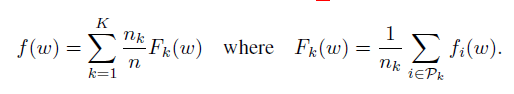

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)

    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    #cce = tf.keras.losses.SquaredHinge()
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    y_pred = model.predict(X_test)
    loss = cce(Y_test, y_pred)
    acc = accuracy_score(tf.argmax(y_pred, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

# Federated Model Training

In [ ]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(input_shape, 10)

#commence global training loop
for comm_round in range(comms_round):

    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)

    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        #local_model = smlp_local.build(784, 10)
        local_model = smlp_local.build(input_shape, 10)
        local_model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)

        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)

        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)

        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        #clear session to free memory after each communication round
        K.clear_session()

    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    #update global model
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, y_test, global_model, comm_round)

comm_round: 0 | global_acc: 90.110% | global_loss: 1.6409269571304321
comm_round: 1 | global_acc: 94.590% | global_loss: 1.551819920539856
comm_round: 2 | global_acc: 95.930% | global_loss: 1.5289334058761597
comm_round: 3 | global_acc: 96.780% | global_loss: 1.5160949230194092
comm_round: 4 | global_acc: 97.110% | global_loss: 1.5091586112976074
comm_round: 5 | global_acc: 97.420% | global_loss: 1.5046546459197998
comm_round: 6 | global_acc: 97.660% | global_loss: 1.4998914003372192
comm_round: 7 | global_acc: 97.820% | global_loss: 1.4975299835205078
comm_round: 8 | global_acc: 97.910% | global_loss: 1.4947277307510376
comm_round: 9 | global_acc: 98.110% | global_loss: 1.4931905269622803
comm_round: 10 | global_acc: 98.140% | global_loss: 1.4917436838150024
comm_round: 11 | global_acc: 98.160% | global_loss: 1.4905918836593628
comm_round: 12 | global_acc: 98.310% | global_loss: 1.4890528917312622
comm_round: 13 | global_acc: 98.430% | global_loss: 1.487945556640625
comm_round: 14 | g

In [ ]:
score1=global_model.evaluate(X_test , y_test , batch_size=batch_size , verbose= 1)
print('Test_acc: {:.3%} | Test_loss: {}'.format( score1[1], score1[0]))

# standard SGD model

In [ ]:
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(batch_size)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(input_shape, 10)

SGD_model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

# fit the SGD training data to model
_ = SGD_model.fit(SGD_dataset, epochs=comms_round, verbose=1 , validation_data=(X_test, y_test))

#test the SGD global model and print out metrics
#for(X_test, y_test) in test_batched:
#        SGD_acc, SGD_loss = test_model(X_test, y_test, SGD_model, 1)

score=SGD_model.evaluate(X_test , y_test , batch_size=batch_size , verbose= 1)

Epoch 1/100
469/469 [==============================] - 3s 7ms/step - loss: 0.8366 - accuracy: 0.7455 - val_loss: 0.2174 - val_accuracy: 0.9362
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2159 - accuracy: 0.9348 - val_loss: 0.1337 - val_accuracy: 0.9604
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1522 - accuracy: 0.9542 - val_loss: 0.0965 - val_accuracy: 0.9716
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1209 - accuracy: 0.9635 - val_loss: 0.0795 - val_accuracy: 0.9760
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1024 - accuracy: 0.9689 - val_loss: 0.0679 - val_accuracy: 0.9790
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0917 - accuracy: 0.9724 - val_loss: 0.0604 - val_accuracy: 0.9810
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0823 - accuracy: 0.9751 - val_loss: 0.0575 - val_accuracy: 0.9813

In [ ]:
print('Test_acc: {:.3%} | Test_loss: {}'.format( score[1], score[0]))

Test_acc: 99.210% | Test_loss: 0.022951742634177208
